In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from functools import reduce

from scipy.interpolate import griddata
import matplotlib.colors as colors
import time

import numpy as np
import DataPreprocessing
import SplitDataSet

In [2]:
def perc_error(true, experimental):
    return 100*tf.abs(tf.divide(true - experimental, true))

def build_model(components=50, activation='relu'):
    #activation = keras.
    model = keras.Sequential([
        keras.layers.Dense(50, activation='elu', input_shape=[8]), #could try swish??  
        keras.layers.Dense(50, activation='elu'),
        
        keras.layers.Dense(1, activation='linear') 
    ])

    adam = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mse', 
                optimizer=adam, metrics=['mape', perc_error])
    return model

In [3]:
def calc_RMSE(mom_train, mom_test, rescaled_train, rescaled_test, reuse_model=False):
    if reuse_model:
        model = build_model()
        model.load_weights("LO/MODEL/uuxg.hdf5")
    else:
        model = build_model()
    
    temp_train = rescaled_train
    temp_test = rescaled_test
    
    scaler = StandardScaler()

    poly_train = np.array([np.ndarray.flatten(np.array(element)) for element in mom_train[:,1:]])
    poly_test = np.array([np.ndarray.flatten(np.array(element)) for element in mom_test[:,1:]])
    poly_train = scaler.fit_transform(poly_train) #Rescale on training set
    poly_test = scaler.transform(poly_test)

    
        # Saves the best model's weights
    checkpoint_path = "LO/MODEL/uuxg.hdf5"
    callback_a = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_best_only=True)
    callback_b = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
    tic = time.perf_counter()
    history = model.fit(poly_train, temp_train, batch_size=256, epochs=1000, 
                        shuffle=True, verbose=1, callbacks=[callback_b, callback_a],
                       validation_data=(poly_test, temp_test), workers=0)
    toc = time.perf_counter()
    print(f"Training ran in {toc - tic:0.4f} seconds")

    try:
        # load the saved model
        saved_model = build_model()
        saved_model.load_weights(checkpoint_path)
        
        
        train_predict = saved_model.predict(poly_train)
        train_predict.shape = (len(train_predict))  
        train_perc = 100*np.mean(np.abs((temp_train - train_predict) / temp_train))                              
        
        tic = time.perf_counter()
        test_predict = saved_model.predict(poly_test)
        toc = time.perf_counter()
        print(f"Prediction ran in {toc - tic:0.4f} seconds")
        
        test_predict.shape = (len(test_predict))
        test_perc = 100*np.mean(np.abs((temp_test - test_predict) / temp_test))

        print('Train: %.3f, Test: %.3f' % (train_perc, test_perc))
        
        np.save('LO/uuxg/pred_nn.npy', test_predict)
        
        return(np.abs((temp_test - test_predict) / temp_test), temp_test**2 - test_predict**2, history)
    except ValueError:
        print('Value Error Encountered')       
    return(0, 0, 0, 0)

In [4]:
##Obtain & process data NPY
me_train, mom_train = SplitDataSet.smallestS('LO/uuxg/me_1000000.npy', 'LO/uuxg/mom_1000000.npy', 1)
me_test, mom_test = SplitDataSet.smallestS('LO/uuxg/me_500000.npy', 'LO/uuxg/mom_500000.npy', 1)

me_swap, mom_swap = SplitDataSet.smallestS('LO/uuxg/me_1000000.npy', 'LO/uuxg/mom_1000000.npy', 2)
mom_swap[:,[0,1]] = mom_swap[:,[1,0]]

mom_train = np.concatenate([mom_train, mom_swap],axis=0)
me_train = np.concatenate([me_train, me_swap],axis=0)

me_swap, mom_swap = SplitDataSet.smallestS('LO/uuxg/me_500000.npy', 'LO/uuxg/mom_500000.npy', 2)
mom_swap[:,[0,1]] = mom_swap[:,[1,0]]

mom_test = np.concatenate([mom_test, mom_swap],axis=0)
me_test = np.concatenate([me_test, me_swap],axis=0)

tic = time.perf_counter()
div_train = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3','2,3'], mom_train))
temp_train = np.multiply(div_train, me_train)
toc = time.perf_counter()
print(f"Test multiplication ran in {toc - tic:0.4f} seconds")

tic = time.perf_counter()
div_test = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3','2,3'], mom_test))
temp_test = np.multiply(div_test, me_test)
toc = time.perf_counter()
print(f"Test multiplication ran in {toc - tic:0.4f} seconds")

Split ran in 2.9155 seconds
Split ran in 1.3031 seconds
Split ran in 2.8244 seconds
Split ran in 1.3272 seconds
Test multiplication ran in 0.1938 seconds
Test multiplication ran in 0.0624 seconds


In [5]:
print('Std : {}'.format(np.std(temp_train)))
print('Mean : {}'.format(np.mean(temp_train)))

std = np.std(temp_train)
print(std)

perc, mse, history = calc_RMSE(mom_train, mom_test, temp_train/std, temp_test/std, reuse_model=False)

Std : 16263.2927268891
Mean : 53557.72625108707
16263.2927268891
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 666692 samples, validate on 332865 samples
Epoch 1/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 0.1929 - mean_absolute_percentage_error: 4.8544 - perc_error: 4.8544 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 1.0183 - val_perc_error: 1.0183

Epoch 2/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 0.0010 - mean_absolute_percentage_error: 0.8014 - perc_error: 0.8014 - val_loss: 5.6871e-04 - val_mean_absolute_percentage_error: 0.6069 - val_perc_error: 0.6069

Epoch 3/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 4.7492e-04 - mean_absolute_percentage_error: 0.5538 - perc_error: 0.5538 - val_loss: 3.8983e-04 - val_me

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 7.2044e-05 - mean_absolute_percentage_error: 0.2163 - perc_error: 0.2163 - val_loss: 9.4541e-05 - val_mean_absolute_percentage_error: 0.2598 - val_perc_error: 0.2598

Epoch 28/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 7.0573e-05 - mean_absolute_percentage_error: 0.2130 - perc_error: 0.2130 - val_loss: 7.3659e-05 - val_mean_absolute_percentage_error: 0.2241 - val_perc_error: 0.2241

Epoch 29/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 6.7852e-05 - mean_absolute_percentage_error: 0.2094 - perc_error: 0.2094 - val_loss: 9.8437e-05 - val_mean_absolute_percentage_error: 0.2631 - val_perc_error: 0.2631

Epoch 30/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - los


Epoch 55/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 4.6405e-05 - mean_absolute_percentage_error: 0.1733 - perc_error: 0.1733 - val_loss: 6.5439e-05 - val_mean_absolute_percentage_error: 0.2095 - val_perc_error: 0.2095

Epoch 56/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 4.5635e-05 - mean_absolute_percentage_error: 0.1704 - perc_error: 0.1704 - val_loss: 4.6240e-05 - val_mean_absolute_percentage_error: 0.1803 - val_perc_error: 0.1803

Epoch 57/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 4.5126e-05 - mean_absolute_percentage_error: 0.1700 - perc_error: 0.1700 - val_loss: 7.6794e-05 - val_mean_absolute_percentage_error: 0.2408 - val_perc_error: 0.2408

Epoch 58/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s


Epoch 83/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 3.6413e-05 - mean_absolute_percentage_error: 0.1502 - perc_error: 0.1502 - val_loss: 2.9850e-05 - val_mean_absolute_percentage_error: 0.1463 - val_perc_error: 0.1463

Epoch 84/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 3.4241e-05 - mean_absolute_percentage_error: 0.1469 - perc_error: 0.1469 - val_loss: 1.6157e-05 - val_mean_absolute_percentage_error: 0.1015 - val_perc_error: 0.1015

Epoch 85/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 3.4020e-05 - mean_absolute_percentage_error: 0.1466 - perc_error: 0.1466 - val_loss: 5.0754e-05 - val_mean_absolute_percentage_error: 0.1876 - val_perc_error: 0.1876

Epoch 86/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 2.6936e-05 - mean_absolute_percentage_error: 0.1291 - perc_error: 0.1291 - val_loss: 4.1092e-05 - val_mean_absolute_percentage_error: 0.1733 - val_perc_error: 0.1733

Epoch 111/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 2.6867e-05 - mean_absolute_percentage_error: 0.1299 - perc_error: 0.1299 - val_loss: 2.9712e-05 - val_mean_absolute_percentage_error: 0.1460 - val_perc_error: 0.1460

Epoch 112/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 2.7585e-05 - mean_absolute_percentage_error: 0.1309 - perc_error: 0.1309 - val_loss: 2.1013e-05 - val_mean_absolute_percentage_error: 0.1162 - val_perc_error: 0.1162

Epoch 113/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 2.1998e-05 - mean_absolute_percentage_error: 0.1168 - perc_error: 0.1168 - val_loss: 3.0614e-05 - val_mean_absolute_percentage_error: 0.1470 - val_perc_error: 0.1470

Epoch 138/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 2.3264e-05 - mean_absolute_percentage_error: 0.1200 - perc_error: 0.1200 - val_loss: 3.8283e-05 - val_mean_absolute_percentage_error: 0.1658 - val_perc_error: 0.1658

Epoch 139/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 2.2428e-05 - mean_absolute_percentage_error: 0.1172 - perc_error: 0.1172 - val_loss: 2.4678e-05 - val_mean_absolute_percentage_error: 0.1297 - val_perc_error: 0.1297

Epoch 140/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 2.0695e-05 - mean_absolute_percentage_error: 0.1106 - perc_error: 0.1106 - val_loss: 1.4808e-05 - val_mean_absolute_percentage_error: 0.1005 - val_perc_error: 0.1005

Epoch 165/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.8858e-05 - mean_absolute_percentage_error: 0.1086 - perc_error: 0.1086 - val_loss: 7.3983e-05 - val_mean_absolute_percentage_error: 0.2315 - val_perc_error: 0.2315

Epoch 166/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 2.0993e-05 - mean_absolute_percentage_error: 0.1118 - perc_error: 0.1118 - val_loss: 2.8298e-05 - val_mean_absolute_percentage_error: 0.1446 - val_perc_error: 0.1446

Epoch 167/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.8624e-05 - mean_absolute_percentage_error: 0.1038 - perc_error: 0.1038 - val_loss: 1.9265e-05 - val_mean_absolute_percentage_error: 0.1120 - val_perc_error: 0.1120

Epoch 192/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.7360e-05 - mean_absolute_percentage_error: 0.1032 - perc_error: 0.1032 - val_loss: 2.5278e-05 - val_mean_absolute_percentage_error: 0.1353 - val_perc_error: 0.1353

Epoch 193/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.7749e-05 - mean_absolute_percentage_error: 0.1047 - perc_error: 0.1047 - val_loss: 1.2061e-05 - val_mean_absolute_percentage_error: 0.0883 - val_perc_error: 0.0883

Epoch 194/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.5841e-05 - mean_absolute_percentage_error: 0.0988 - perc_error: 0.0988 - val_loss: 7.6285e-06 - val_mean_absolute_percentage_error: 0.0695 - val_perc_error: 0.0695

Epoch 219/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.6268e-05 - mean_absolute_percentage_error: 0.0994 - perc_error: 0.0994 - val_loss: 1.6232e-05 - val_mean_absolute_percentage_error: 0.1065 - val_perc_error: 0.1065

Epoch 220/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.6667e-05 - mean_absolute_percentage_error: 0.0983 - perc_error: 0.0983 - val_loss: 8.9739e-06 - val_mean_absolute_percentage_error: 0.0782 - val_perc_error: 0.0782

Epoch 221/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.5644e-05 - mean_absolute_percentage_error: 0.0972 - perc_error: 0.0972 - val_loss: 1.6557e-05 - val_mean_absolute_percentage_error: 0.1060 - val_perc_error: 0.1060

Epoch 246/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.5462e-05 - mean_absolute_percentage_error: 0.0963 - perc_error: 0.0963 - val_loss: 8.5505e-06 - val_mean_absolute_percentage_error: 0.0774 - val_perc_error: 0.0774

Epoch 247/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.5077e-05 - mean_absolute_percentage_error: 0.0967 - perc_error: 0.0967 - val_loss: 1.3087e-05 - val_mean_absolute_percentage_error: 0.0896 - val_perc_error: 0.0896

Epoch 248/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.4847e-05 - mean_absolute_percentage_error: 0.0931 - perc_error: 0.0931 - val_loss: 1.0640e-05 - val_mean_absolute_percentage_error: 0.0795 - val_perc_error: 0.0795

Epoch 273/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.4211e-05 - mean_absolute_percentage_error: 0.0909 - perc_error: 0.0909 - val_loss: 6.9946e-05 - val_mean_absolute_percentage_error: 0.2098 - val_perc_error: 0.2098

Epoch 274/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.3993e-05 - mean_absolute_percentage_error: 0.0926 - perc_error: 0.0926 - val_loss: 1.2121e-05 - val_mean_absolute_percentage_error: 0.0944 - val_perc_error: 0.0944

Epoch 275/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.3461e-05 - mean_absolute_percentage_error: 0.0902 - perc_error: 0.0902 - val_loss: 2.5804e-05 - val_mean_absolute_percentage_error: 0.1227 - val_perc_error: 0.1227

Epoch 300/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.3837e-05 - mean_absolute_percentage_error: 0.0914 - perc_error: 0.0914 - val_loss: 2.4405e-05 - val_mean_absolute_percentage_error: 0.1256 - val_perc_error: 0.1256

Epoch 301/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.4407e-05 - mean_absolute_percentage_error: 0.0941 - perc_error: 0.0941 - val_loss: 6.7188e-06 - val_mean_absolute_percentage_error: 0.0673 - val_perc_error: 0.0673

Epoch 302/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.3140e-05 - mean_absolute_percentage_error: 0.0890 - perc_error: 0.0890 - val_loss: 9.3996e-06 - val_mean_absolute_percentage_error: 0.0811 - val_perc_error: 0.0811

Epoch 327/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.3508e-05 - mean_absolute_percentage_error: 0.0897 - perc_error: 0.0897 - val_loss: 6.6020e-05 - val_mean_absolute_percentage_error: 0.2007 - val_perc_error: 0.2007

Epoch 328/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.2279e-05 - mean_absolute_percentage_error: 0.0862 - perc_error: 0.0862 - val_loss: 1.0774e-05 - val_mean_absolute_percentage_error: 0.0900 - val_perc_error: 0.0900

Epoch 329/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.3100e-05 - mean_absolute_percentage_error: 0.0877 - perc_error: 0.0877 - val_loss: 2.5349e-05 - val_mean_absolute_percentage_error: 0.1402 - val_perc_error: 0.1402

Epoch 354/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.2247e-05 - mean_absolute_percentage_error: 0.0852 - perc_error: 0.0852 - val_loss: 1.7675e-05 - val_mean_absolute_percentage_error: 0.1043 - val_perc_error: 0.1043

Epoch 355/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.1982e-05 - mean_absolute_percentage_error: 0.0850 - perc_error: 0.0850 - val_loss: 1.0938e-05 - val_mean_absolute_percentage_error: 0.0868 - val_perc_error: 0.0868

Epoch 356/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.1813e-05 - mean_absolute_percentage_error: 0.0837 - perc_error: 0.0837 - val_loss: 3.0033e-05 - val_mean_absolute_percentage_error: 0.1542 - val_perc_error: 0.1542

Epoch 381/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.1563e-05 - mean_absolute_percentage_error: 0.0831 - perc_error: 0.0831 - val_loss: 1.1151e-05 - val_mean_absolute_percentage_error: 0.0884 - val_perc_error: 0.0884

Epoch 382/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.2206e-05 - mean_absolute_percentage_error: 0.0843 - perc_error: 0.0843 - val_loss: 1.4623e-05 - val_mean_absolute_percentage_error: 0.1039 - val_perc_error: 0.1039

Epoch 383/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.0915e-05 - mean_absolute_percentage_error: 0.0791 - perc_error: 0.0791 - val_loss: 1.3344e-05 - val_mean_absolute_percentage_error: 0.0966 - val_perc_error: 0.0966

Epoch 408/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.1376e-05 - mean_absolute_percentage_error: 0.0830 - perc_error: 0.0830 - val_loss: 5.4443e-06 - val_mean_absolute_percentage_error: 0.0611 - val_perc_error: 0.0611

Epoch 409/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.0625e-05 - mean_absolute_percentage_error: 0.0788 - perc_error: 0.0788 - val_loss: 7.3234e-06 - val_mean_absolute_percentage_error: 0.0731 - val_perc_error: 0.0731

Epoch 410/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.0157e-05 - mean_absolute_percentage_error: 0.0772 - perc_error: 0.0772 - val_loss: 4.1113e-06 - val_mean_absolute_percentage_error: 0.0521 - val_perc_error: 0.0521

Epoch 435/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.0644e-05 - mean_absolute_percentage_error: 0.0803 - perc_error: 0.0803 - val_loss: 2.0490e-05 - val_mean_absolute_percentage_error: 0.1237 - val_perc_error: 0.1237

Epoch 436/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.0765e-05 - mean_absolute_percentage_error: 0.0803 - perc_error: 0.0803 - val_loss: 5.4335e-06 - val_mean_absolute_percentage_error: 0.0612 - val_perc_error: 0.0612

Epoch 437/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.0636e-05 - mean_absolute_percentage_error: 0.0778 - perc_error: 0.0778 - val_loss: 6.8110e-06 - val_mean_absolute_percentage_error: 0.0706 - val_perc_error: 0.0706

Epoch 462/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.0025e-05 - mean_absolute_percentage_error: 0.0751 - perc_error: 0.0751 - val_loss: 2.7731e-05 - val_mean_absolute_percentage_error: 0.1345 - val_perc_error: 0.1345

Epoch 463/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 1.0168e-05 - mean_absolute_percentage_error: 0.0782 - perc_error: 0.0782 - val_loss: 7.9854e-06 - val_mean_absolute_percentage_error: 0.0764 - val_perc_error: 0.0764

Epoch 464/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 8.9510e-06 - mean_absolute_percentage_error: 0.0731 - perc_error: 0.0731 - val_loss: 3.3047e-06 - val_mean_absolute_percentage_error: 0.0476 - val_perc_error: 0.0476

Epoch 489/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 8.9036e-06 - mean_absolute_percentage_error: 0.0728 - perc_error: 0.0728 - val_loss: 4.7986e-06 - val_mean_absolute_percentage_error: 0.0587 - val_perc_error: 0.0587

Epoch 490/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 9.2905e-06 - mean_absolute_percentage_error: 0.0746 - perc_error: 0.0746 - val_loss: 6.4517e-06 - val_mean_absolute_percentage_error: 0.0666 - val_perc_error: 0.0666

Epoch 491/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 9.3603e-06 - mean_absolute_percentage_error: 0.0733 - perc_error: 0.0733 - val_loss: 3.9801e-06 - val_mean_absolute_percentage_error: 0.0520 - val_perc_error: 0.0520

Epoch 516/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 8.8041e-06 - mean_absolute_percentage_error: 0.0720 - perc_error: 0.0720 - val_loss: 3.9805e-06 - val_mean_absolute_percentage_error: 0.0489 - val_perc_error: 0.0489

Epoch 517/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 8.6835e-06 - mean_absolute_percentage_error: 0.0719 - perc_error: 0.0719 - val_loss: 9.7300e-06 - val_mean_absolute_percentage_error: 0.0823 - val_perc_error: 0.0823

Epoch 518/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 8.6207e-06 - mean_absolute_percentage_error: 0.0704 - perc_error: 0.0704 - val_loss: 1.5325e-05 - val_mean_absolute_percentage_error: 0.0982 - val_perc_error: 0.0982

Epoch 543/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 8.7485e-06 - mean_absolute_percentage_error: 0.0711 - perc_error: 0.0711 - val_loss: 6.7289e-06 - val_mean_absolute_percentage_error: 0.0626 - val_perc_error: 0.0626

Epoch 544/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 8.4443e-06 - mean_absolute_percentage_error: 0.0689 - perc_error: 0.0689 - val_loss: 2.7667e-05 - val_mean_absolute_percentage_error: 0.1385 - val_perc_error: 0.1385

Epoch 545/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 8.3441e-06 - mean_absolute_percentage_error: 0.0701 - perc_error: 0.0701 - val_loss: 5.3901e-06 - val_mean_absolute_percentage_error: 0.0589 - val_perc_error: 0.0589

Epoch 570/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 8.6375e-06 - mean_absolute_percentage_error: 0.0693 - perc_error: 0.0693 - val_loss: 3.2427e-06 - val_mean_absolute_percentage_error: 0.0473 - val_perc_error: 0.0473

Epoch 571/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 8.2816e-06 - mean_absolute_percentage_error: 0.0689 - perc_error: 0.0689 - val_loss: 4.8715e-06 - val_mean_absolute_percentage_error: 0.0513 - val_perc_error: 0.0513

Epoch 572/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 7.5018e-06 - mean_absolute_percentage_error: 0.0646 - perc_error: 0.0646 - val_loss: 6.2866e-06 - val_mean_absolute_percentage_error: 0.0687 - val_perc_error: 0.0687

Epoch 597/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 8.6238e-06 - mean_absolute_percentage_error: 0.0695 - perc_error: 0.0695 - val_loss: 1.2591e-05 - val_mean_absolute_percentage_error: 0.0919 - val_perc_error: 0.0919

Epoch 598/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 7.8393e-06 - mean_absolute_percentage_error: 0.0672 - perc_error: 0.0672 - val_loss: 7.5664e-06 - val_mean_absolute_percentage_error: 0.0685 - val_perc_error: 0.0685

Epoch 599/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 7.5814e-06 - mean_absolute_percentage_error: 0.0657 - perc_error: 0.0657 - val_loss: 8.4271e-06 - val_mean_absolute_percentage_error: 0.0771 - val_perc_error: 0.0771

Epoch 624/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 7.9973e-06 - mean_absolute_percentage_error: 0.0675 - perc_error: 0.0675 - val_loss: 4.6232e-06 - val_mean_absolute_percentage_error: 0.0550 - val_perc_error: 0.0550

Epoch 625/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 7.4639e-06 - mean_absolute_percentage_error: 0.0662 - perc_error: 0.0662 - val_loss: 5.9691e-06 - val_mean_absolute_percentage_error: 0.0617 - val_perc_error: 0.0617

Epoch 626/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 8us/step - loss: 7.6409e-06 - mean_absolute_percentage_error: 0.0628 - perc_error: 0.0628 - val_loss: 2.7804e-06 - val_mean_absolute_percentage_error: 0.0428 - val_perc_error: 0.0428

Epoch 651/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 6.8464e-06 - mean_absolute_percentage_error: 0.0626 - perc_error: 0.0626 - val_loss: 9.4958e-06 - val_mean_absolute_percentage_error: 0.0801 - val_perc_error: 0.0801

Epoch 652/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 6.9850e-06 - mean_absolute_percentage_error: 0.0634 - perc_error: 0.0634 - val_loss: 1.5230e-05 - val_mean_absolute_percentage_error: 0.0913 - val_perc_error: 0.0913

Epoch 653/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 7.7890e-06 - mean_absolute_percentage_error: 0.0646 - perc_error: 0.0646 - val_loss: 1.7632e-05 - val_mean_absolute_percentage_error: 0.1150 - val_perc_error: 0.1150

Epoch 678/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 6.9072e-06 - mean_absolute_percentage_error: 0.0622 - perc_error: 0.0622 - val_loss: 6.5092e-06 - val_mean_absolute_percentage_error: 0.0629 - val_perc_error: 0.0629

Epoch 679/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 7.0368e-06 - mean_absolute_percentage_error: 0.0611 - perc_error: 0.0611 - val_loss: 2.0988e-06 - val_mean_absolute_percentage_error: 0.0376 - val_perc_error: 0.0376

Epoch 680/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 6.6407e-06 - mean_absolute_percentage_error: 0.0602 - perc_error: 0.0602 - val_loss: 5.3304e-06 - val_mean_absolute_percentage_error: 0.0521 - val_perc_error: 0.0521

Epoch 705/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 6.2057e-06 - mean_absolute_percentage_error: 0.0599 - perc_error: 0.0599 - val_loss: 1.7994e-05 - val_mean_absolute_percentage_error: 0.1138 - val_perc_error: 0.1138

Epoch 706/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - loss: 7.4809e-06 - mean_absolute_percentage_error: 0.0638 - perc_error: 0.0638 - val_loss: 2.2045e-06 - val_mean_absolute_percentage_error: 0.0382 - val_perc_error: 0.0382

Epoch 707/1000
666692/666692 [==============================]666692/666692 [==============================] - 6s 9us/step - 

In [6]:
from matplotlib import rcParams

rcParams['font.family'] = 'Serif'
rcParams['font.size'] = 11

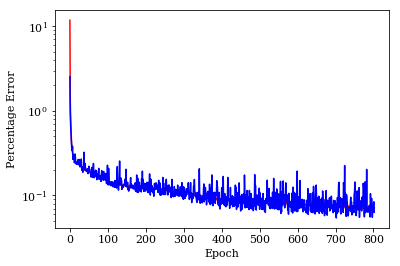

In [7]:
##LEARNING CURVE
points = len(history.history['loss'])
pyplot.plot(range(points), history.history['mean_absolute_percentage_error'], color='r', label='Training Set')
pyplot.plot(range(points), history.history['val_mean_absolute_percentage_error'],color='b', label='Val Set')
#pyplot.legend()
#pyplot.ylim(0,2)

pyplot.xlabel('Epoch')
pyplot.ylabel('Percentage Error')
pyplot.yscale('log')

In [ ]:
"LO/MODEL/uuxg.hdf5"

In [ ]:
s12, s13, s23 = DataPreprocessing.mandel_creation(['1,2','1,3','2,3'], mom_test_r)
S = s12 + s13 + s23

In [ ]:
x1 = np.divide(s12, 1000000)
x2 = np.divide(s13, 1000000)
x3 = np.divide(s23, 1000000)

x2i = np.linspace(0, 1, 500) #x1 coordinates
x3i = np.linspace(0, 1, 500) #x2 coordinates
X2i, X3i = np.meshgrid(x2i, x3i) #2d regularly spaced grid of coordinates.

In [ ]:
grid = griddata((x2, x3), perc, (X2i, X3i), method='linear')

In [ ]:
fig, ax = pyplot.subplots(figsize=(5, 3))
im = ax.pcolor(grid, cmap = 'nipy_spectral_r', norm = colors.LogNorm()) #color map of coord grid
cbar = ax.figure.colorbar(im)
cbar.set_label('Percentage Error')

ax.set_xticks([0, 500])
ax.set_xticklabels([0, 1])
ax.set_yticks([0, 500])
ax.set_yticklabels([0, 1])


ax.set_ylabel('x2')
ax.set_xlabel('x3')
pyplot.savefig('errordalitz_nnet_3jetLO')

###DIVERGENT REGIONS


me_train, mom_train = SplitDataSet.smallestS('LO/uuxg/me_1000000.npy', 'LO/uuxg/mom_1000000.npy', 1)
me_test, mom_test = SplitDataSet.smallestS('LO/uuxg/me_500000.npy', 'LO/uuxg/mom_500000.npy', 1)

me_swap, mom_swap = SplitDataSet.smallestS('LO/uuxg/me_1000000.npy', 'LO/uuxg/mom_1000000.npy', 2)
mom_swap[:,[0,1]] = mom_swap[:,[1,0]]

mom_train = np.concatenate([mom_train, mom_swap],axis=0)
me_train = np.concatenate([me_train, me_swap],axis=0)

me_swap, mom_swap = SplitDataSet.smallestS('LO/uuxg/me_500000.npy', 'LO/uuxg/mom_500000.npy', 2)
mom_swap[:,[0,1]] = mom_swap[:,[1,0]]

mom_test = np.concatenate([mom_test, mom_swap],axis=0)
me_test = np.concatenate([me_test, me_swap],axis=0)
